In [1]:
import os
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import _pickle as cPickle
import matplotlib.pyplot as plt

DATA_PATH = './cifar-10-python'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
random.seed(123)
tf.set_random_seed(123)
np.random.seed(123)

In [3]:
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin-1')
    return dict

def one_hot(labels, vals=10):
    n = len(labels)
    out = np.zeros((n, vals))
    out[range(n), labels] = 1
    return out

def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
    plt.imshow(im)
    plt.show()
    
class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None

    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d['data'] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float)/255
        self.labels = one_hot(np.hstack([d['labels'] for d in data]), 10)
        return self
    
    def next_batch(self, batch_size):
        x = self.images[self._i: self._i+batch_size]
        y = self.labels[self._i: self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y
    
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(['data_batch_{}'.format(i) for i in range(1, 6)]).load()
        self.test = CifarLoader(['test_batch']).load()
        
cifar = CifarDataManager()

In [4]:
print('number of train images : {}'.format(len(cifar.train.images)))
print('number of train labels : {}'.format(len(cifar.train.labels)))
print('number of test images : {}'.format(len(cifar.test.images)))
print('number of test labels : {}'.format(len(cifar.test.labels)))

number of train images : 50000
number of train labels : 50000
number of test images : 10000
number of test labels : 10000


In [5]:
images = cifar.train.images

In [6]:
#print(cifar.train.images[0])
#print(cifar.train.images.shape)
#print(cifar.train.labels.shape)
#display_cifar(images, 10)

In [7]:
init_weight = tf.initializers.truncated_normal(stddev=0.1)
init_bias = tf.initializers.constant(0.1)

In [8]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.float32, shape=[None, 10])
rate = tf.placeholder(tf.float32)

In [9]:
#conv 3 * 3 필터 3개 (rgb) 16개 (conv -> pull)
w1 = tf.Variable(init_weight(shape=[3,3,3,16], dtype=tf.float32))
b1 = tf.Variable(init_bias(shape=[16]), dtype=tf.float32)
conv1 = tf.nn.relu(tf.nn.conv2d(x, w1, strides=[1,1,1,1], padding='SAME')+b1)
#conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
conv1.shape
#conv1_pool.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(16)])

In [10]:
#conv 5*5 * 16 필터 32개
w2 = tf.Variable(init_weight(shape=[5,5,16,32], dtype=tf.float32))
b2 = tf.Variable(init_bias(shape=[32]), dtype=tf.float32)
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, w2, strides=[1,1,1,1], padding='SAME')+b2)
#conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
conv2.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [11]:
w3 = tf.Variable(init_weight(shape=[3,3,32,64], dtype=tf.float32))
b3 = tf.Variable(init_bias(shape=[64]), dtype=tf.float32)
conv3 = tf.nn.relu(tf.nn.conv2d(conv2, w3, strides=[1,1,1,1], padding='SAME')+b3)
conv3_pool = tf.nn.max_pool(conv3, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
#conv3_pool.shape
conv3_pool_pool = tf.nn.max_pool(conv3_pool, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
conv3_pool_pool.shape

TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(64)])

In [12]:
conv3_flat = tf.reshape(conv3_pool_pool, [-1, 4*4*64])
#conv3_pool.shape

In [13]:
#fully connected layer
w4 = tf.Variable(init_weight(shape=[4*4*64, 10], dtype=tf.float32))
b4 = tf.Variable(init_bias(shape=[10]), dtype=tf.float32)
full1 = tf.matmul(conv3_flat ,w4)+b4
#full1 = tf.nn.relu(tf.matmul(conv3_flat, w4)+b4)
#full1_drop = tf.nn.dropout(full1, rate=rate)


In [14]:
#w5 = tf.Variable(init_weight(shape=[1024, 10], dtype=tf.float32))
#b5 = tf.Variable(init_bias(shape=[10]), dtype=tf.float32)
#full2 = tf.matmul(full1_drop, w5)+b5


In [15]:
logits = full1
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits = logits))
train = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
#train = tf.train.MomentumOptimizer(0.005 , 0.9, use_nesterov = True).minimize(loss)

In [16]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
x_test = cifar.test.images.reshape(10, 1000, 32, 32, 3)
y_test = cifar.test.labels.reshape(10, 1000, 10)

def test(sess):
    acc = np.mean([sess.run(accuracy, feed_dict={x: x_test[i], y: y_test[i], rate: 0.0}) for i in range(10)])
    print('test accuracy: {:.5}%'.format(acc*100))

In [18]:
TRAIN_SIZE = 50000  
BATCH_SIZE = 100
STEPS = TRAIN_SIZE // BATCH_SIZE
EPOCH = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(EPOCH):
        for j in range(STEPS):
            batch = cifar.train.next_batch(BATCH_SIZE)
            _, loss_, acc = sess.run([train, loss, accuracy], feed_dict={x: batch[0], y: batch[1], rate: 0.5})
            
            if j%299 == 0:
                print('epoch: {}, steps: {}, train-loss: {}, train-accuracy: {}'.format(i+1, j+1, loss_, acc))
        test(sess)     
sess.close()

epoch: 1, steps: 1, train-loss: 4.872832298278809, train-accuracy: 0.10999999940395355
epoch: 1, steps: 300, train-loss: 1.6077282428741455, train-accuracy: 0.38999998569488525
test accuracy: 41.82%
epoch: 2, steps: 1, train-loss: 1.6016900539398193, train-accuracy: 0.44999998807907104
epoch: 2, steps: 300, train-loss: 1.224971055984497, train-accuracy: 0.5199999809265137
test accuracy: 52.69%
epoch: 3, steps: 1, train-loss: 1.2571525573730469, train-accuracy: 0.5899999737739563
epoch: 3, steps: 300, train-loss: 1.012699007987976, train-accuracy: 0.6299999952316284
test accuracy: 59.14%
epoch: 4, steps: 1, train-loss: 1.0959677696228027, train-accuracy: 0.6100000143051147
epoch: 4, steps: 300, train-loss: 0.8931588530540466, train-accuracy: 0.699999988079071
test accuracy: 61.57%
epoch: 5, steps: 1, train-loss: 0.9851298332214355, train-accuracy: 0.699999988079071
epoch: 5, steps: 300, train-loss: 0.7914770245552063, train-accuracy: 0.7699999809265137
test accuracy: 63.45%
epoch: 6, st

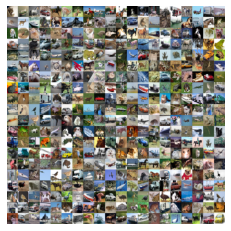

In [24]:
images = cifar.train.images
display_cifar(images,20)